**Model Source:**<br />
https://github.com/kuangliu/pytorch-cifar/blob/49b7aa97b0c12fe0d4054e670403a16b6b834ddd/models/dla_simple.py

# Setup Variables

MNIST, FashionMNIST, GTSRB, Cifar10

In [1]:
DATASET = 'GTSRB'
SEED = 42
CUDA = 0
GPU_NAME = f'cuda:{CUDA}'

In [2]:
import os
from pathlib import Path

base = Path().cwd()

if base.name != 'runtime-monitoring':
    os.chdir('../')
    base = Path().cwd()

base

PosixPath('/home/ah19/runtime-monitoring')

# Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from fastprogress import progress_bar, master_bar

import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchinfo import summary


cudnn.benchmark = True
torch.set_float32_matmul_precision('high')

In [4]:
from utilities.utils import *
from utilities.pathManager import fetchPaths
from utilities.scaleFunctions import *
from utilities.pcaFunctions import *

In [5]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

# Paths

In [6]:
paths = fetchPaths(base, DATASET, '', False)
path_data = paths['data']

configs = load_json(paths['configuration'])
config = configs['configuration']
model_setup = configs['model_setup']
model_config = configs['model_config']
optim_name = list(config['optimizer'].keys())[0]
optim_args = config['optimizer'][optim_name]
scheduler_name = list(config['scheduler'].keys())[0]
scheduler_args = config['scheduler'][scheduler_name]

# GPU Device & Seed

In [7]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [8]:
device = get_device(GPU_NAME)
torch.cuda.get_device_name(device)

'NVIDIA A100 80GB PCIe'

## Load model and settings

In [9]:
# transformers
from models.transformers import transformers
tf_train = transformers[DATASET.lower()]['train']
tf_test = transformers[DATASET.lower()]['test']

In [10]:
from models.mnist_model import MNIST_Model
from models.fashionmnist_model import FashionMNIST_CNN
from models.gtsrb_model import GTSRB_CNN
from models.cifar10_dla import Cifar10_DLA
from models.cifar10_model import Cifar10_CNN

models = {
    'mnist': MNIST_Model,
    'fashionmnist': FashionMNIST_CNN,
    'gtsrb': GTSRB_CNN,
#     'cifar10': Cifar10_DLA,
    'cifar10': Cifar10_CNN
}

model_ = models[DATASET.lower()]

### Configurations

In [11]:
lhl = 30

# Load / Split / DataLoader

In [12]:
feature_names = get_labels(DATASET)

train_data = get_dataset(DATASET, path_data, train=True, transform=tf_train)
test_data = get_dataset(DATASET, path_data, train=False, transform=tf_test)
len(train_data), len(test_data)

(63999, 4223)

In [13]:
trainloader = get_dataLoader(train_data, model_config['batch_size'], True)
testloader = get_dataLoader(test_data, model_config['batch_size'], False)

In [14]:
tf_denormalize = T.Normalize(
    mean=[-m / s for m, s in zip(tf_train.transforms[-1].mean, tf_train.transforms[-1].std)],
    std=[1/s for s in tf_train.transforms[-1].std]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


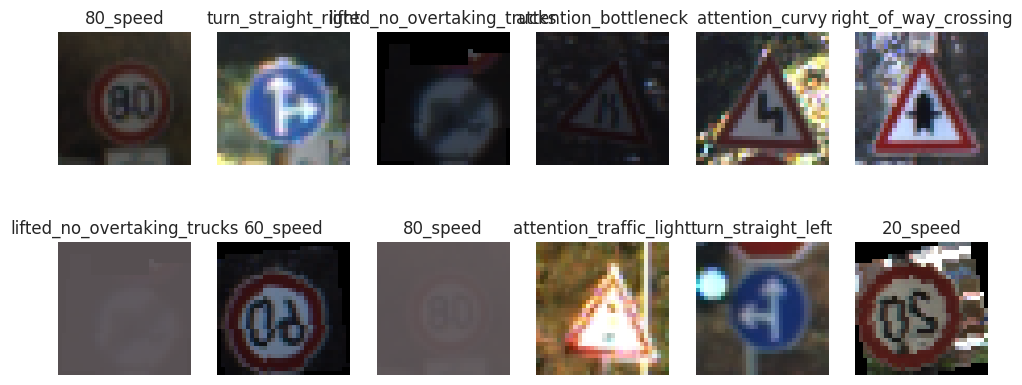

In [15]:
show_images_loader(trainloader, feature_names=feature_names, transform=tf_denormalize)

# Helper Functions

In [16]:
model_setup['last_hidden_neurons'] = lhl

model = model_(**model_setup).to(device)
model = torch.compile(model)
nn.DataParallel(model, device_ids=[CUDA])

DataParallel(
  (module): OptimizedModule(
    (_orig_mod): GTSRB_CNN(
      (relu): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
      (scaleInputs): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout_l): Dropout(p=0.25, inplace=False)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (cn1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn3): Conv2d(256, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (cn4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (bn4): BatchNorm2d(64, eps=1e

In [17]:
# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer and scheduler
optimizer = getattr(torch.optim, optim_name)(model.parameters(), lr=model_config['lr'], **optim_args)
scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, **scheduler_args)

In [18]:
# training testing attributes
kwargs = {
    'model': model,
    'loss_function': loss_function,
    'optimizer': optimizer,
    'lr_scheduler': scheduler,
    'map_classes': None,
    'skip_classes': None,
    'device': device,
    'model_path': None,
    'trainloader': trainloader,
    'testloader': testloader,
    'config': model_config
}

## Run Training

In [ ]:
# train
train_losses, test_losses, train_accs, test_accs, test_loss, test_acc, confusion_matrix_test, best_model_name = \
run_training_testing(**kwargs)

[2023-07-16 10:57:06,063] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
